Pointnet for supervised removal of the terrain and low vegetation, unfortunately I could not find any pre-trained models for transfer learning so it is Pointnet from scratch trained on the treeinstance dataset

Data pre-processing

Also a lot of ways of visualizing pointcloud don't work in jupyter, and a lot of those that work in jupyter do not work in google colab. Working with open3d pointclouds seemed like a good idea, but there exists no random crop, and no easy way to use crop for random cropping, so I returned to xyz + categories.

Much later on I found a way to use pointcloud inside jupyter, as seen in the visualization of a pointcloud and normalized values

In [1]:
#import what might be needed
!pip install open3d
!pip install laspy
!pip install torchmetrics
#https://github.com/itberrios/3D/blob/main/s3dis_raw_explorer.ipynb
#how the data for Pointnet was preprocessed
import laspy
import torch.optim as optim
import torchmetrics
from torchmetrics.classification import MulticlassMatthewsCorrCoef
import os
import re
import math
import random
from glob import glob
import time
import numpy as np
import pandas as pd
import open3d as o3
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 137.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 84.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 75.5 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.1/86.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 36.2 MB/s eta 0:00:00


In [ ]:
#0: Unclassified (scattered points that were not annotated)
#	 		1: Low-vegetation (anything that is not a tree or ground)
#	 		2: Terrain
#	 		3: Out-points (trees outside of the measured/annotated plots)
#	 		4: Stem
#	 		5: Live-branches (green crown)
#	 		6: Woody-branches
#So for this case point with 0 will be removed, 1 and 2 will be separate classes,
#3 will be removed, and 4 and 5 and 6 are going to be class 0.
#Segmentation will be 0 as tree, 1 as low-veg, and 2 as terrain, for a total of
#three classes
!unzip FORinstance_dataset.zip

Archive:  FORinstance_dataset.zip
   creating: CULS/
  inflating: CULS/plot_1_annotated.las  
  inflating: CULS/plot_2_annotated.las  
  inflating: CULS/plot_3_annotated.las  
  inflating: CULS/tree_data_CULS.csv  
  inflating: data_split_metadata.csv  
   creating: NIBIO/
  inflating: NIBIO/plot_10_annotated.las  
  inflating: NIBIO/plot_11_annotated.las  
  inflating: NIBIO/plot_12_annotated.las  
  inflating: NIBIO/plot_13_annotated.las  
  inflating: NIBIO/plot_16_annotated.las  
  inflating: NIBIO/plot_17_annotated.las  
  inflating: NIBIO/plot_18_annotated.las  
  inflating: NIBIO/plot_19_annotated.las  
  inflating: NIBIO/plot_1_annotated.las  
  inflating: NIBIO/plot_21_annotated.las  
  inflating: NIBIO/plot_22_annotated.las  
  inflating: NIBIO/plot_23_annotated.las  
  inflating: NIBIO/plot_2_annotated.las  
  inflating: NIBIO/plot_3_annotated.las  
  inflating: NIBIO/plot_4_annotated.las  
  inflating: NIBIO/plot_5_annotated.las  
  inflating: NIBIO/plot_6_annotated.las  
 

In [ ]:
#based on metadata, dev was split by me (LN) into train and val, while test was
#placed in test
trainingpath=["CULS/plot_1_annotated.las",
              "NIBIO/plot_10_annotated.las",
              "NIBIO/plot_11_annotated.las",
              "NIBIO/plot_12_annotated.las",
              "NIBIO/plot_16_annotated.las",
              "NIBIO/plot_2_annotated.las",
              "NIBIO/plot_21_annotated.las",
              "NIBIO/plot_3_annotated.las",
              "NIBIO/plot_4_annotated.las",
              "NIBIO/plot_6_annotated.las",
              "NIBIO/plot_7_annotated.las",
              "NIBIO/plot_9_annotated.las",
              "RMIT/train.las",
              "SCION/plot_35_annotated.las",
              "SCION/plot_39_annotated.las",
              "TUWIEN/train.las"
              ]

validationpath=["CULS/plot_3_annotated.las",
                "NIBIO/plot_13_annotated.las",
                "NIBIO/plot_19_annotated.las",
                "NIBIO/plot_8_annotated.las",
                "SCION/plot_87_annotated.las"
                ]

testingpath=["CULS/plot_2_annotated.las",
             "NIBIO/plot_1_annotated.las",
             "NIBIO/plot_17_annotated.las",
             "NIBIO/plot_18_annotated.las",
             "NIBIO/plot_22_annotated.las",
             "NIBIO/plot_23_annotated.las",
             "NIBIO/plot_5_annotated.las",
             "RMIT/test.las",
             "SCION/plot_31_annotated.las",
             "SCION/plot_61_annotated.las",
             "TUWIEN/test.las"
             ]

In [ ]:
#os.mkdir("PreprocessedData")
#os.mkdir("PreprocessedData/Train")
#os.mkdir("PreprocessedData/Val")
#os.mkdir("PreprocessedData/Test")
os.mkdir("ProcessedData")
os.mkdir("ProcessedData/Train")
os.mkdir("ProcessedData/Val")
os.mkdir("ProcessedData/Test")
#preprocessed was the pointclouds of open3d, but it was easier to work with the data as XYZcat
#also, it gets even more processed later on so calling it preprocessed felt off

In [ ]:
#0: Unclassified (scattered points that were not annotated)
#	 		1: Low-vegetation (anything that is not a tree or ground)
#	 		2: Terrain
#	 		3: Out-points (trees outside of the measured/annotated plots)
#	 		4: Stem
#	 		5: Live-branches (green crown)
#	 		6: Woody-branches
#So for this case point with 0 will be removed, 1 and 2 will be separate classes,
#3 will be removed, and 4 and 5 and 6 are going to be class 0.
#Segmentation will be 0 as tree, 1 as low-veg, and 2 as terrain, for a total of
#three classes

In [ ]:
#awa=laspy.read("TUWIEN/train.las")
#print(awa.x,awa.y,awa.z)
#print(list(awa.point_format.dimension_names))
#print(awa['classification'])
#del awa
#this is a rest to see that laspy read works

In [ ]:
#from https://github.com/itberrios/3D/blob/main/s3dis_raw_explorer.ipynb
#to follow how the original data was preprocessed and create enough for use of batches
def get_slice(points, xyz_s, xpart, ypart):
    ''' Obtains Point Cloud Slices from the (x,y) partitions
        By default this will obtain roughly 1x1 partitions
        inputs:
            points - (array) could be xyz, rgb or any input array
            xyz_s - (Nx3 array) 0 min shifter point cloud array
            xpart - xpartitions [[lower, upper]]
            ypart - ypartitions [[lower, upper]]
        '''
    x_slice = (xyz_s[:, 0] >= xpart[0]) \
              & (xyz_s[:, 0] <= xpart[1])

    y_slice = (xyz_s[:, 1] >= ypart[0]) \
              & (xyz_s[:, 1] <= ypart[1])
#creates masks to get all points within both the x and y bounds declared in xpart and ypart
    return points[x_slice & y_slice, :]
def get_partitions(xyz, xyz_s, c=1.):
    ''' Obtains Point Cloud Space Partitions
        Inputs:
            xyz_s - (Nx3 array) 0 min shifted point cloud array
            c - (float) factor for deciding how many partitions to create (larger --> less partitions)
        Outputs:
            partitions - (tuple) x and y parition arrays with
                         format: [[lower, upper]]
        '''
    ## get number of x, y bins
    range_ = np.abs(xyz.max(axis=0) - xyz.min(axis=0))
    num_xbins, num_ybins, _ = np.uint8(np.round(range_ / c))

    # uncomment this to generate ~1x1m partitions
    # num_xbins, num_ybins, _ = np.uint8(np.ceil(np.max(xyz_s, 0)))

    ## get x, y bins
    _, xbins = np.histogram(xyz_s[:, 0], bins=num_xbins)
    _, ybins = np.histogram(xyz_s[:, 1], bins=num_ybins)

    ## get x y space partitions
    x_parts = np.vstack((xbins[:-1], xbins[1:])).T
    y_parts = np.vstack((ybins[:-1], ybins[1:])).T

    return x_parts, y_parts

In [ ]:
def toPointcloud(datalas):
  #empty cloud to put points into
  pointcloud=o3.t.geometry.PointCloud()
  #add the points in by concat and then transpose
  points = np.vstack((datalas.x, datalas.y, datalas.z)).transpose()
  #get categories
  categories=np.array(datalas['classification'])[:, None]
  #remove the classes that were unwanted
  mask=np.bitwise_or(categories>=4,categories==1)
  mask=np.bitwise_or(mask,categories==2)
  points=points[mask[:,0],:]
  categories=categories[mask]
  #rename all tree-based classes into class 0
  categories[categories>=4]=0
  #add into the pointcloud
  pointcloud.point.positions=o3.core.Tensor(points)
  #add in the class as a 'class' attribute to the points
  pointcloud.point['class']=o3.core.Tensor(categories).reshape((-1, 1))
  return pointcloud

def toXYZCAT(datalas):
  #get and concatenate all positional points in XYZ order
  XYZ=np.vstack((datalas.x, datalas.y, datalas.z)).transpose()
  #get the categories a.k.a. classes
  categories=np.array(datalas['classification'])[:, None]
  #remove the classes that were unwanted by creating masks
  #that only leave classes equal to or above 4 (tree)
  #or equal to 1 (low veg) or equal to 2 (terrain)
  mask=np.bitwise_or(categories>=4,categories==1)
  mask=np.bitwise_or(mask,categories==2)
  XYZ=XYZ[mask[:,0],:]
  categories=categories[mask]
  #rename all tree-based classes (branches and stem) into class 0
  categories[categories>=4]=0
  return XYZ,categories.reshape((-1, 1))

#part of preprocessing and saving the processed data
trainnewpath='ProcessedData/Train'
valnewpath='ProcessedData/Val'
testnewpath='ProcessedData/Test'
i=0

for names in trainingpath:
  traindata=laspy.read(names)
  #traindata=toPointcloud(traindata)
  traindata,cat=toXYZCAT(traindata)
  #space data is both positional and category data
  space_data=np.concatenate((traindata,cat),1)
  #all positions start at 0 in xyz_s
  xyz_s = traindata - traindata.min(axis=0)
  #get bounds to create partitions from the data
  x_parts, y_parts = get_partitions(traindata, xyz_s, c=4)
  for x_part in x_parts:
            for y_part in y_parts:
              #get partition from the xpart and ypart bounds
              space_slice = pd.DataFrame(get_slice(space_data, xyz_s, x_part, y_part))
            # only save if partition has at least 100 points:
              if len(space_slice) > 100:
                  i += 1
                  save_path = os.path.join(trainnewpath, f'_partition{i}_.hdf5')
                  space_slice.to_hdf(save_path, key='space_slice')
  #save_path = os.path.join(trainnewpath,f'num{i}.ply')
  #o3.t.io.write_point_cloud(filename=save_path,pointcloud=traindata)#,format='auto',write_ascii = False, compressed = False, print_progress = False)
del traindata
#delete for space reasons, then repeat same process for val and test data

for names in validationpath:
  valdata=laspy.read(names)
 # valdata=toPointcloud(valdata)
  valdata,cat=toXYZCAT(valdata)
  space_data=np.concatenate((valdata,cat),1)
  xyz_s = valdata - valdata.min(axis=0)
  x_parts, y_parts = get_partitions(valdata, xyz_s, c=4)
  for x_part in x_parts:
            for y_part in y_parts:
              space_slice = pd.DataFrame(get_slice(space_data, xyz_s, x_part, y_part))
            # only save if partition has at least 100 points:
              if len(space_slice) > 100:
                  i += 1
                  save_path = os.path.join(valnewpath, f'_partition{i}_.hdf5')
                  space_slice.to_hdf(save_path, key='space_slice')
  #save_path = os.path.join(valnewpath,f'num{i}.ply')
  #o3.t.io.write_point_cloud(filename=save_path,pointcloud=valdata)#,format='auto',write_ascii = False, compressed = False, print_progress = False)
del valdata

for names in testingpath:
  testdata=laspy.read(names)
  #testdata=toPointcloud(testdata)
  testdata,cat=toXYZCAT(testdata)
  space_data=np.concatenate((testdata,cat),1)
  xyz_s = testdata - testdata.min(axis=0)
  x_parts, y_parts = get_partitions(testdata, xyz_s, c=4)
  for x_part in x_parts:
            for y_part in y_parts:
              space_slice = pd.DataFrame(get_slice(space_data, xyz_s, x_part, y_part))
            # only save if partition has at least 100 points:
              if len(space_slice) > 100:
                  i += 1
                  save_path = os.path.join(testnewpath, f'_partition{i}_.hdf5')
                  space_slice.to_hdf(save_path, key='space_slice')
  #save_path = os.path.join(testnewpath,f'num{i}.ply')
  #o3.t.io.write_point_cloud(filename=save_path,pointcloud=testdata)#,format='auto',write_ascii = False, compressed = False, print_progress = False)
del testdata


(1489912, 3)
(1489912, 1)
(2424552, 3)
(2424552, 1)
(3901835, 3)
(3901835, 1)
(4077893, 3)
(4077893, 1)
(2868472, 3)
(2868472, 1)
(3050386, 3)
(3050386, 1)
(3011665, 3)
(3011665, 1)
(3104980, 3)
(3104980, 1)
(3062979, 3)
(3062979, 1)
(2209843, 3)
(2209843, 1)
(2345284, 3)
(2345284, 1)
(2513461, 3)
(2513461, 1)
(1368827, 3)
(1368827, 1)
(2410078, 3)
(2410078, 1)
(1576136, 3)
(1576136, 1)
(5936991, 3)
(5936991, 1)


In [ ]:
#stuff to test how masks work
#a=np.asarray([1,2,3,4,5])
#b=np.asarray([[11,22,33,44,55],[66,77,88,99,100]])
#print(a.shape)
#print(b.shape)
#mask=np.bitwise_or(a==1,a==2)
#mask=np.bitwise_or(mask,a>=5)
#a=a[mask]
#b=b[:,mask]
#print(a)
#print(b)
#print(a.shape)
#print(b.shape)


In [ ]:
!zip -r ProcessedData.zip ProcessedData

  adding: ProcessedData/ (stored 0%)
  adding: ProcessedData/Train/ (stored 0%)
  adding: ProcessedData/Train/_partition693_.hdf5 (deflated 72%)
  adding: ProcessedData/Train/_partition311_.hdf5 (deflated 79%)
  adding: ProcessedData/Train/_partition98_.hdf5 (deflated 80%)
  adding: ProcessedData/Train/_partition812_.hdf5 (deflated 71%)
  adding: ProcessedData/Train/_partition259_.hdf5 (deflated 79%)
  adding: ProcessedData/Train/_partition32_.hdf5 (deflated 74%)
  adding: ProcessedData/Train/_partition1039_.hdf5 (deflated 72%)
  adding: ProcessedData/Train/_partition1075_.hdf5 (deflated 75%)
  adding: ProcessedData/Train/_partition958_.hdf5 (deflated 71%)
  adding: ProcessedData/Train/_partition915_.hdf5 (deflated 74%)
  adding: ProcessedData/Train/_partition1043_.hdf5 (deflated 72%)
  adding: ProcessedData/Train/_partition133_.hdf5 (deflated 79%)
  adding: ProcessedData/Train/_partition1050_.hdf5 (deflated 72%)
  adding: ProcessedData/Train/_partition667_.hdf5 (deflated 73%)
  adding

In [ ]:
#I found a way to actually visualize it
pathtostuff=os.path.join(trainnewpath,"_partition999_.hdf5")
testingtesting = pd.read_hdf(pathtostuff, key='space_slice').to_numpy()

#categories, a.k.a. classes
CATEGORIES = {
    'tree'  : 0,
    'low_veg'    : 1,
    'ter'     : 2
}

#which colour per category
COLOR_MAP = {
    0  : (34, 139, 34),   # tree - forestgreen
    1  : (255, 0, 0),    # low vegetation - red
    2 : (138, 232, 170) #  terrain - cyan-ish
}

#lambda enables to wait for an input which will arrive in the future
#which is the targets(categories), and the category number will be used to access the color map dictionary
#to get the colours for tree, low_veg, and terrain
#if there are no points, this crashes np.vectorize
#so when it is time for point removal, pcd.colors will have to be in an if statement
v_map_colors = np.vectorize(lambda x : COLOR_MAP[x])

#3 classes from how many categories there are
NUM_CLASSES = len(CATEGORIES)

#get positional points, points with origin at 0, and categories
points=testingtesting[:,:3]
points=points-points.min(axis=0)
targets=testingtesting[:,3]

#make it into open3d pointcloud for plotly to be able to draw it
pcd = o3.geometry.PointCloud()
pcd.points = o3.utility.Vector3dVector(points)
pcd.colors = o3.utility.Vector3dVector(np.vstack(v_map_colors(targets)).T/255)

# draw(pcd)
o3.visualization.draw_plotly([pcd])

PointNet

In [2]:
!unzip ProcessedData

Archive:  ProcessedData.zip
   creating: ProcessedData/
   creating: ProcessedData/Train/
  inflating: ProcessedData/Train/_partition693_.hdf5  
  inflating: ProcessedData/Train/_partition311_.hdf5  
  inflating: ProcessedData/Train/_partition98_.hdf5  
  inflating: ProcessedData/Train/_partition812_.hdf5  
  inflating: ProcessedData/Train/_partition259_.hdf5  
  inflating: ProcessedData/Train/_partition32_.hdf5  
  inflating: ProcessedData/Train/_partition1039_.hdf5  
  inflating: ProcessedData/Train/_partition1075_.hdf5  
  inflating: ProcessedData/Train/_partition958_.hdf5  
  inflating: ProcessedData/Train/_partition915_.hdf5  
  inflating: ProcessedData/Train/_partition1043_.hdf5  
  inflating: ProcessedData/Train/_partition133_.hdf5  
  inflating: ProcessedData/Train/_partition1050_.hdf5  
  inflating: ProcessedData/Train/_partition667_.hdf5  
  inflating: ProcessedData/Train/_partition19_.hdf5  
  inflating: ProcessedData/Train/_partition35_.hdf5  
  inflating: ProcessedData/Tra

In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [4]:
'''
Contains classes comprising Point Net Architecture. Usage for each class can
be found in main() at the bottom.

TO use: Import Classification and Segmentation classes into desired script
#or use within same script/notebook

NOTE:
This architecture does not cover Part Segmentation. Per the Point Net paper
that is a different architecture and is not implemented here.
'''
#see link below for the pointnet from scratch tutorial
#https://medium.com/@itberrios6/point-net-from-scratch-78935690e496
import torch
import torch.nn as nn
import torch.nn.functional as F


# ============================================================================
# T-net (Spatial Transformer Network)
class Tnet(nn.Module):
    ''' T-Net learns a Transformation matrix with a specified dimension '''
    def __init__(self, dim, num_points=2500):
        super(Tnet, self).__init__()

        # dimensions for transform matrix
        self.dim = dim

        self.conv1 = nn.Conv1d(dim, 64, kernel_size=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=1)
        self.conv3 = nn.Conv1d(128, 1024, kernel_size=1)

        self.linear1 = nn.Linear(1024, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, dim**2)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

        self.max_pool = nn.MaxPool1d(kernel_size=num_points)


    def forward(self, x):
        bs = x.shape[0]

        # pass through shared MLP layers (conv1d)
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.bn3(F.relu(self.conv3(x)))

        # max pool over num points
        x = self.max_pool(x).view(bs, -1)

        # pass through MLP
        x = self.bn4(F.relu(self.linear1(x)))
        x = self.bn5(F.relu(self.linear2(x)))
        x = self.linear3(x)

        # initialize identity matrix
        iden = torch.eye(self.dim, requires_grad=True).repeat(bs, 1, 1)
        if x.is_cuda:
            iden = iden.cuda()

        x = x.view(-1, self.dim, self.dim) + iden

        return x


# ============================================================================
# Point Net Backbone (main Architecture)
class PointNetBackbone(nn.Module):
    '''
    This is the main portion of Point Net before the classification and segmentation heads.
    The main function of this network is to obtain the local and global point features,
    which can then be passed to each of the heads to perform either classification or
    segmentation. The forward pass through the backbone includes both T-nets and their
    transformations, the shared MLPs, and the max pool layer to obtain the global features.

    The forward function either returns the global or combined (local and global features)
    along with the critical point index locations and the feature transformation matrix. The
    feature transformation matrix is used for a regularization term that will help it become
    orthogonal. (i.e. a rigid body transformation is an orthogonal transform and we would like
    to maintain orthogonality in high dimensional space). "An orthogonal transformations preserves
    the lengths of vectors and angles between them"
    '''
    def __init__(self, num_points=2500, num_global_feats=1024, local_feat=True):
        ''' Initializers:
                num_points - number of points in point cloud
                num_global_feats - number of Global Features for the main
                                   Max Pooling layer
                local_feat - if True, forward() returns the concatenation
                             of the local and global features
            '''
        super(PointNetBackbone, self).__init__()

        # if true concat local and global features
        self.num_points = num_points
        self.num_global_feats = num_global_feats
        self.local_feat = local_feat

        # Spatial Transformer Networks (T-nets)
        self.tnet1 = Tnet(dim=3, num_points=num_points)
        self.tnet2 = Tnet(dim=64, num_points=num_points)

        # shared MLP 1
        self.conv1 = nn.Conv1d(3, 64, kernel_size=1)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=1)

        # shared MLP 2
        self.conv3 = nn.Conv1d(64, 64, kernel_size=1)
        self.conv4 = nn.Conv1d(64, 128, kernel_size=1)
        self.conv5 = nn.Conv1d(128, self.num_global_feats, kernel_size=1)

        # batch norms for both shared MLPs
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(64)
        self.bn4 = nn.BatchNorm1d(128)
        self.bn5 = nn.BatchNorm1d(self.num_global_feats)

        # max pool to get the global features
        self.max_pool = nn.MaxPool1d(kernel_size=num_points, return_indices=True)


    def forward(self, x):

        # get batch size
        bs = x.shape[0]

        # pass through first Tnet to get transform matrix
        A_input = self.tnet1(x)

        # perform first transformation across each point in the batch
        x = torch.bmm(x.transpose(2, 1), A_input).transpose(2, 1)

        # pass through first shared MLP
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))

        # get feature transform
        A_feat = self.tnet2(x)

        # perform second transformation across each (64 dim) feature in the batch
        x = torch.bmm(x.transpose(2, 1), A_feat).transpose(2, 1)

        # store local point features for segmentation head
        local_features = x.clone()

        # pass through second MLP
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.bn4(F.relu(self.conv4(x)))
        x = self.bn5(F.relu(self.conv5(x)))

        # get global feature vector and critical indexes
        global_features, critical_indexes = self.max_pool(x)
        global_features = global_features.view(bs, -1)
        critical_indexes = critical_indexes.view(bs, -1)

        if self.local_feat:
            features = torch.cat((local_features,
                                  global_features.unsqueeze(-1).repeat(1, 1, self.num_points)),
                                  dim=1)

            return features, critical_indexes, A_feat

        else:
            return global_features, critical_indexes, A_feat

# ============================================================================
# Segmentation Head, this is the one that will be used for this project
class PointNetSegHead(nn.Module):
    ''' Segmentation Head '''
    def __init__(self, num_points=2500, num_global_feats=1024, m=2):
        super(PointNetSegHead, self).__init__()

        self.num_points = num_points
        self.m = m

        # get the backbone
        self.backbone = PointNetBackbone(num_points, num_global_feats, local_feat=True)

        # shared MLP
        num_features = num_global_feats + 64 # local and global features
        self.conv1 = nn.Conv1d(num_features, 512, kernel_size=1)
        self.conv2 = nn.Conv1d(512, 256, kernel_size=1)
        self.conv3 = nn.Conv1d(256, 128, kernel_size=1)
        self.conv4 = nn.Conv1d(128, m, kernel_size=1)

        # batch norms for shared MLP
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(128)


    def forward(self, x):

        # get combined features
        x, crit_idxs, A_feat = self.backbone(x)

        # pass through shared MLP
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.conv4(x)

        x = x.transpose(2, 1)

        return x, crit_idxs, A_feat

# ============================================================================
# Test that everything works on random points
def main():
    test_data = torch.rand(32, 3, 2500)

    ## test T-net
    tnet = Tnet(dim=3)
    transform = tnet(test_data)
    print(f'T-net output shape: {transform.shape}')

    ## test backbone
    pointfeat = PointNetBackbone(local_feat=False)
    out, _, _ = pointfeat(test_data)
    print(f'Global Features shape: {out.shape}')

    pointfeat = PointNetBackbone(local_feat=True)
    out, _, _ = pointfeat(test_data)
    print(f'Combined Features shape: {out.shape}')

    # test on single batch (should throw error if there is an issue)
    pointfeat = PointNetBackbone(local_feat=True).eval()
    out, _, _ = pointfeat(test_data[0, :, :].unsqueeze(0))

    ## test segmentation head
    seg = PointNetSegHead(m=3)
    out, _, _ = seg(test_data)
    print(f'Seg shape: {out.shape}')

if __name__ == '__main__':
    main()

T-net output shape: torch.Size([32, 3, 3])
Global Features shape: torch.Size([32, 1024])
Combined Features shape: torch.Size([32, 1088, 2500])
Seg shape: torch.Size([32, 2500, 3])


More preprocessing to match how the data was for the original pointnet

In [5]:
#somewhat changed class from the article
class Processed(Dataset):
    def __init__(self, split='train', npoints=15000, r_prob=0.1):
        self.root = "ProcessedData"
        self.split = split.lower() # use 'test' in order to bypass augmentations
        self.npoints = npoints     # use  None to sample all the points
        self.r_prob = r_prob       # probability of rotation
        #which data to make a dataset on is decided by the split
        if split=='train':
          topath=trainnewpath
        elif split=='val':
          topath=valnewpath
        else:
          topath=testnewpath
        # get all datapaths
        self.data_paths = []
        self.data_paths += glob(os.path.join(topath, '*.hdf5'),
                                    recursive=True)

        # get unique space identifiers (?? / _partition?_.hdf5)
        self.space_ids = []
        for fp in self.data_paths:
            area, space = fp.split('/')[-2:]
            space_id = area + '/' + space
            #space_id = '/'.join([area, '_'.join(space.split('_')[:2])]) + '_'
            self.space_ids.append(space_id)

        self.space_ids = list(set(self.space_ids))


    def __getitem__(self, idx):
        # read data from hdf5
        space_data = pd.read_hdf(self.data_paths[idx], key='space_slice').to_numpy()
        points = space_data[:, :3] # xyz points
        targets = space_data[:, 3]    # integer categories

        # down sample point cloud
        #if npoints are higher than number of points, it will instead create duplicate points
        if self.npoints:
            points, targets = self.downsample(points, targets)

        # add Gaussian noise to point set if not testing for less overfitting and more general model
        if self.split != 'test':
            # add N(0, 1/100) noise
            points += np.random.normal(0., 0.01, points.shape)

            # add random rotation to the point cloud with probability
            if np.random.uniform(0, 1) > 1 - self.r_prob:
                points = self.random_rotate(points)


        # Normalize Point Cloud to (0, 1)
        points = self.normalize_points(points)

        # convert to torch
        points = torch.from_numpy(points).type(torch.float32)
        targets = torch.from_numpy(targets).type(torch.LongTensor)

        return points, targets


    def get_random_partitioned_space(self):
        ''' Obtains a Random space. In this case the batchsize would be
            the number of partitons that the space was separated into.
            This is a special function for testing.
            '''

        # get random space id
        idx = random.randint(0, len(self.space_ids) - 1)
        space_id = self.space_ids[idx]

        # get all filepaths for randomly selected space
        space_paths = []
        for fpath in self.data_paths:
            if space_id in fpath:
                space_paths.append(fpath)

        # assume npoints is very large if not passed
        if not self.npoints:
            self.npoints = 20000

        points = np.zeros((len(space_paths), self.npoints, 3))
        targets = np.zeros((len(space_paths), self.npoints))

        # obtain data
        for i, space_path in enumerate(space_paths):
            space_data = pd.read_hdf(space_path, key='space_slice').to_numpy()
            _points = space_data[:, :3] # xyz points
            _targets = space_data[:, 3] # integer categories

            # downsample point cloud
            _points, _targets = self.downsample(_points, _targets)

            # add points and targets to batch arrays
            points[i] = _points
            targets[i] = _targets

        # convert to torch
        points = torch.from_numpy(points).type(torch.float32)
        targets = torch.from_numpy(targets).type(torch.LongTensor)

        return points, targets


    def downsample(self, points, targets):
        if len(points) > self.npoints:
            choice = np.random.choice(len(points), self.npoints, replace=False)
        else:
            # case when there are less points than the desired number
            choice = np.random.choice(len(points), self.npoints, replace=True)
        points = points[choice, :]
        targets = targets[choice]

        return points, targets


    @staticmethod
    def random_rotate(points):
        ''' randomly rotates point cloud about vertical axis.
            Code is commented out to rotate about all axes
            '''
        # construct a randomly parameterized 3x3 rotation matrix
        phi = np.random.uniform(-np.pi, np.pi)
        theta = np.random.uniform(-np.pi, np.pi)
        psi = np.random.uniform(-np.pi, np.pi)

        rot_x = np.array([
            [1,              0,                 0],
            [0, np.cos(phi), -np.sin(phi)],
            [0, np.sin(phi), np.cos(phi) ]])

        rot_y = np.array([
            [np.cos(theta),  0, np.sin(theta)],
            [0,                 1,                0],
            [-np.sin(theta), 0, np.cos(theta)]])

        rot_z = np.array([
            [np.cos(psi), -np.sin(psi), 0],
            [np.sin(psi), np.cos(psi),  0],
            [0,              0,                 1]])

        # rot = np.matmul(rot_x, np.matmul(rot_y, rot_z))

        return np.matmul(points, rot_z)


    @staticmethod
    def normalize_points(points):
        ''' Perform min/max normalization on points
            Same as:
            (x - min(x))/(max(x) - min(x))
            '''
        points = points - points.min(axis=0)
        points /= points.max(axis=0)

        return points


    def __len__(self):
        return len(self.data_paths)

In [6]:
#Hyper parameters, hoping this won't kill my RAM, but it will take a while to train
NUM_TRAIN_POINTS = 15000 # train/valid points, hopefully not too few to learn
NUM_TEST_POINTS = 25000 #test points per section
BATCH_SIZE = 4 #4 partitions per batch

In [7]:
trainnewpath='ProcessedData/Train'
valnewpath='ProcessedData/Val'
testnewpath='ProcessedData/Test'

In [8]:
#create datasets with the Processed class, this rotates, adds gaussian noise, and samples
tree_train = Processed(npoints=NUM_TRAIN_POINTS, r_prob=0.1) #rotation probability 10%
tree_valid = Processed(split='val',npoints=NUM_TRAIN_POINTS, r_prob=0.0)
tree_test = Processed(split='test', npoints=NUM_TEST_POINTS,r_prob=0.0)

# get dataloaders
train_dataloader = DataLoader(tree_train, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(tree_valid, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(tree_test, batch_size=BATCH_SIZE, shuffle=False)

In [9]:
CATEGORIES = {
    'tree'  : 0,
    'low_veg'    : 1,
    'ter'     : 2
}
COLOR_MAP = {
    0  : (34, 139, 34),   # tree - forestgreen
    1  : (255, 0, 0),    # low vegetation - red
    2 : (138, 232, 170) #  terrain - cyan-ish
}
v_map_colors = np.vectorize(lambda x : COLOR_MAP[x])

NUM_CLASSES = len(CATEGORIES)

points, targets = tree_train[100]

pcd = o3.geometry.PointCloud()
pcd.points = o3.utility.Vector3dVector(points)
pcd.colors = o3.utility.Vector3dVector(np.vstack(v_map_colors(targets)).T/255)

# draw(pcd)
o3.visualization.draw_plotly([pcd])

Training

In [10]:
#Testing testing, does it work?
points, targets = next(iter(train_dataloader))

seg_model = PointNetSegHead(num_points=NUM_TRAIN_POINTS, m=NUM_CLASSES)
out, _, _ = seg_model(points.transpose(2, 1))
print(f'Seg shape: {out.shape}')

Seg shape: torch.Size([4, 15000, 3])


In [11]:
mcc_metric = MulticlassMatthewsCorrCoef(num_classes=NUM_CLASSES).to(DEVICE)
def compute_iou(targets, predictions):

    targets = targets.reshape(-1)
    predictions = predictions.reshape(-1)

    intersection = torch.sum(predictions == targets) # true positives
    union = len(predictions) + len(targets) - intersection

    return intersection / union

In [12]:
#Their special loss function which adds Dice loss and Focal loss together to be
# able to pick and choose which classes weigh more (trees) and make sure it
#won't mix and match too much when segmenting (rather than a patchwork of
#terrain and low veg or low veg and tree when unsure, it will classify
#as one of them. Kind of like KNN or clustering)
class PointNetSegLoss(nn.Module):
    def __init__(self, alpha=None, gamma=0, size_average=True, dice=False):
        super(PointNetSegLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.size_average = size_average
        self.dice = dice

        # sanitize inputs
        if isinstance(alpha,(float, int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,(list, np.ndarray)): self.alpha = torch.Tensor(alpha)

        # get Balanced Cross Entropy Loss
        self.cross_entropy_loss = nn.CrossEntropyLoss(weight=self.alpha)


    def forward(self, predictions, targets, pred_choice=None):

        # get Balanced Cross Entropy Loss
        ce_loss = self.cross_entropy_loss(predictions.transpose(2, 1), targets)

        # reformat predictions (b, n, c) -> (b*n, c)
        predictions = predictions.contiguous() \
                                 .view(-1, predictions.size(2))
        # get predicted class probabilities for the true class
        pn = F.softmax(predictions)
        pn = pn.gather(1, targets.view(-1, 1)).view(-1)

        # compute loss (negative sign is included in ce_loss)
        loss = ((1 - pn)**self.gamma * ce_loss)
        if self.size_average: loss = loss.mean()
        else: loss = loss.sum()

        # add dice coefficient if necessary
        if self.dice: return loss + self.dice_loss(targets, pred_choice, eps=1)
        else: return loss


    @staticmethod
    def dice_loss(predictions, targets, eps=1):
        ''' Compute Dice loss, directly compare predictions with truth '''

        targets = targets.reshape(-1)
        predictions = predictions.reshape(-1)

        cats = torch.unique(targets)

        top = 0
        bot = 0
        for c in cats:
            locs = targets == c

            # get truth and predictions for each class
            y_tru = targets[locs]
            y_hat = predictions[locs]

            top += torch.sum(y_hat == y_tru)
            bot += len(y_tru) + len(y_hat)


        return 1 - 2*((top + eps)/(bot + eps))

In [25]:
#Training
EPOCHS = 10
LR = 0.0001
alpha = np.ones(len(CATEGORIES))
alpha[1:3] *= 0.25 # balance less important classes
#it matters more that it finds all trees rather than
#classifying between low vegetation and terrain
#but I still believe that keeping them separate
#makes it easier
seg_model = PointNetSegHead(num_points=NUM_TRAIN_POINTS, m=NUM_CLASSES)
gamma = 1

optimizer = optim.Adam(seg_model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-6, max_lr=1e-3,
                                              step_size_up=1000, cycle_momentum=False)
criterion = PointNetSegLoss(alpha=alpha, gamma=gamma, dice=True).to(DEVICE)

seg_model = seg_model.to(DEVICE)

In [14]:
os.mkdir("trained_models")
os.mkdir("trained_models/seg_focal_dice_iou_rot_clr")

In [26]:
# store best validation iou
best_iou = 0.5
best_mcc = 0.5

# lists to store metrics
train_loss = []
train_accuracy = []
train_mcc = []
train_iou = []
valid_loss = []
valid_accuracy = []
valid_mcc = []
valid_iou = []

num_train_batch = int(np.ceil(len(tree_train)/BATCH_SIZE))
num_valid_batch = int(np.ceil(len(tree_valid)/BATCH_SIZE))

for epoch in range(1, EPOCHS + 1):
    # place model in training mode
    seg_model = seg_model.train()
    _train_loss = []
    _train_accuracy = []
    _train_mcc = []
    _train_iou = []
    for i, (points, targets) in enumerate(train_dataloader, 0):

        points = points.transpose(2, 1).to(DEVICE)
        targets = targets.squeeze().to(DEVICE)

        # zero gradients
        optimizer.zero_grad()

        # get predicted class logits
        preds, _, _ = seg_model(points)

        # get class predictions
        pred_choice = torch.softmax(preds, dim=2).argmax(dim=2)

        # get loss and perform backprop
        loss = criterion(preds, targets, pred_choice)
        loss.backward()
        optimizer.step()
        scheduler.step() # update learning rate

        # get metrics
        correct = pred_choice.eq(targets.data).cpu().sum()
        accuracy = correct/float(BATCH_SIZE*NUM_TRAIN_POINTS)
        mcc = mcc_metric(preds.transpose(2, 1), targets)
        iou = compute_iou(targets, pred_choice)

        # update epoch loss and accuracy
        _train_loss.append(loss.item())
        _train_accuracy.append(accuracy)
        _train_mcc.append(mcc.item())
        _train_iou.append(iou.item())

        if i % 100 == 0:
            print(f'\t [{epoch}: {i}/{num_train_batch}] ' \
                  + f'train loss: {loss.item():.4f} ' \
                  + f'accuracy: {accuracy:.4f} ' \
                  + f'mcc: {mcc:.4f} ' \
                  + f'iou: {iou:.4f}')

    train_loss.append(np.mean(_train_loss))
    train_accuracy.append(np.mean(_train_accuracy))
    train_mcc.append(np.mean(_train_mcc))
    train_iou.append(np.mean(_train_iou))

    print(f'Epoch: {epoch} - Train Loss: {train_loss[-1]:.4f} ' \
          + f'- Train Accuracy: {train_accuracy[-1]:.4f} ' \
          + f'- Train MCC: {train_mcc[-1]:.4f} ' \
          + f'- Train IOU: {train_iou[-1]:.4f}')

    # pause to cool down
    time.sleep(4)

    # get test results after each epoch
    with torch.no_grad():

        # place model in evaluation mode
        seg_model = seg_model.eval()

        _valid_loss = []
        _valid_accuracy = []
        _valid_mcc = []
        _valid_iou = []
        for i, (points, targets) in enumerate(valid_dataloader, 0):

            points = points.transpose(2, 1).to(DEVICE)
            targets = targets.squeeze().to(DEVICE)

            preds, _, A = seg_model(points)
            pred_choice = torch.softmax(preds, dim=2).argmax(dim=2)

            loss = criterion(preds, targets, pred_choice)

            # get metrics
            correct = pred_choice.eq(targets.data).cpu().sum()
            accuracy = correct/float(BATCH_SIZE*NUM_TRAIN_POINTS)
            mcc = mcc_metric(preds.transpose(2, 1), targets)
            iou = compute_iou(targets, pred_choice)

            # update epoch loss and accuracy
            _valid_loss.append(loss.item())
            _valid_accuracy.append(accuracy)
            _valid_mcc.append(mcc.item())
            _valid_iou.append(iou.item())

            if i % 100 == 0:
                print(f'\t [{epoch}: {i}/{num_valid_batch}] ' \
                  + f'valid loss: {loss.item():.4f} ' \
                  + f'accuracy: {accuracy:.4f} '
                  + f'mcc: {mcc:.4f} ' \
                  + f'iou: {iou:.4f}')

        valid_loss.append(np.mean(_valid_loss))
        valid_accuracy.append(np.mean(_valid_accuracy))
        valid_mcc.append(np.mean(_valid_mcc))
        valid_iou.append(np.mean(_valid_iou))
        print(f'Epoch: {epoch} - Valid Loss: {valid_loss[-1]:.4f} ' \
              + f'- Valid Accuracy: {valid_accuracy[-1]:.4f} ' \
              + f'- Valid MCC: {valid_mcc[-1]:.4f} ' \
              + f'- Valid IOU: {valid_iou[-1]:.4f}')


        # pause to cool down
        time.sleep(4)

    # save best models
    if valid_iou[-1] >= best_iou:
        best_iou = valid_iou[-1]
        torch.save(seg_model.state_dict(), f'trained_models/seg_focal_dice_iou_rot_clr/seg_model_{epoch}.pth')


	 [1: 0/269] train loss: 1.5933 accuracy: 0.2364 mcc: -0.1383 iou: 0.1340
	 [1: 100/269] train loss: 0.9388 accuracy: 0.5851 mcc: 0.3931 iou: 0.4135
	 [1: 200/269] train loss: 1.4708 accuracy: 0.3552 mcc: 0.1158 iou: 0.2160
Epoch: 1 - Train Loss: 1.1936 - Train Accuracy: 0.4433 - Train MCC: 0.1628 - Train IOU: 0.2967
	 [1: 0/67] valid loss: 1.2554 accuracy: 0.6230 mcc: 0.4196 iou: 0.4524
Epoch: 1 - Valid Loss: 307.9571 - Valid Accuracy: 0.4992 - Valid MCC: 0.2575 - Valid IOU: 0.3488
	 [2: 0/269] train loss: 1.1124 accuracy: 0.5354 mcc: 0.1351 iou: 0.3655
	 [2: 100/269] train loss: 1.0742 accuracy: 0.4670 mcc: 0.3844 iou: 0.3047
	 [2: 200/269] train loss: 0.5946 accuracy: 0.6012 mcc: 0.4087 iou: 0.4298
Epoch: 2 - Train Loss: 0.9357 - Train Accuracy: 0.5339 - Train MCC: 0.2881 - Train IOU: 0.3793
	 [2: 0/67] valid loss: 1.4536 accuracy: 0.5212 mcc: 0.0870 iou: 0.3524
Epoch: 2 - Valid Loss: 4.3711 - Valid Accuracy: 0.4760 - Valid MCC: 0.1980 - Valid IOU: 0.3301
	 [3: 0/269] train loss: 0.

In [16]:
#original batch is way too high, lowered it to 8
#My RAM is dying so I switched batch to 4 rather than 8
#I am scared that it might be the model itself which takes up too much RAM...
#Using a GPU and cuda for processing is much faster and saves RAM
#but it can only be used for 5 hours rather than 85 hours

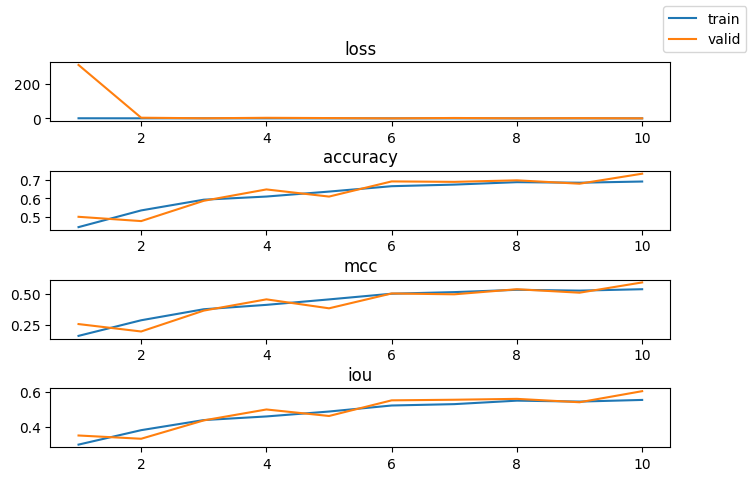

In [27]:
fig, ax = plt.subplots(4, 1, figsize=(8, 5))
ax[0].plot(np.arange(1, EPOCHS + 1), train_loss, label='train')
ax[0].plot(np.arange(1, EPOCHS + 1), valid_loss, label='valid')
ax[0].set_title('loss')

ax[1].plot(np.arange(1, EPOCHS + 1), train_accuracy)
ax[1].plot(np.arange(1, EPOCHS + 1), valid_accuracy)
ax[1].set_title('accuracy')

ax[2].plot(np.arange(1, EPOCHS + 1), train_mcc)
ax[2].plot(np.arange(1, EPOCHS + 1), valid_mcc)
ax[2].set_title('mcc')

ax[3].plot(np.arange(1, EPOCHS + 1), train_iou)
ax[3].plot(np.arange(1, EPOCHS + 1), valid_iou)
ax[3].set_title('iou')

fig.legend(loc='upper right')
plt.subplots_adjust(wspace=0., hspace=0.85)

In [31]:
#look at graph to pick best model
MODEL_PATH = 'trained_models/seg_focal_dice_iou_rot_clr/seg_model_6.pth'

model = PointNetSegHead(num_points=NUM_TEST_POINTS, m=NUM_CLASSES).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval();

In [32]:
#I cannot see any softmax without an explicit dim
#either I am blind or the warning means something else
import warnings
warnings.simplefilter("ignore", UserWarning)
#but at least this will stop the spam in output

In [33]:
num_test_batch = int(np.ceil(len(tree_test)/BATCH_SIZE))

total_test_targets = []
total_test_preds = []

with torch.no_grad():

    # place model in evaluation mode
    model = model.eval()

    test_loss = []
    test_accuracy = []
    test_mcc = []
    test_iou = []
    for i, (points, targets) in enumerate(test_dataloader, 0):

        points = points.transpose(2, 1).to(DEVICE)
        targets = targets.squeeze().to(DEVICE)

        preds, _, A = model(points)
        pred_choice = torch.softmax(preds, dim=2).argmax(dim=2)
        if preds.size()==torch.Size([1, 25000, 3]):
          print("There's something that went wrong, skipping this one")
          continue
        loss = criterion(preds, targets, pred_choice)

        # get metrics
        correct = pred_choice.eq(targets.data).cpu().sum()
        accuracy = correct/float(BATCH_SIZE*NUM_TEST_POINTS)
        mcc = mcc_metric(preds.transpose(2, 1), targets)
        iou = compute_iou(targets, pred_choice)

        # update epoch loss and accuracy
        test_loss.append(loss.item())
        test_accuracy.append(accuracy)
        test_mcc.append(mcc.item())
        test_iou.append(iou.item())

        # add to total targets/preds
        total_test_targets += targets.reshape(-1).cpu().numpy().tolist()
        total_test_preds += pred_choice.reshape(-1).cpu().numpy().tolist()

        if i % 50 == 0:
            print(f'\t [{i}/{num_test_batch}] ' \
                  + f'test loss: {loss.item():.4f} ' \
                  + f'accuracy: {accuracy:.4f} ' \
                  + f'mcc: {mcc:.4f} ' \
                  + f'iou: {iou:.4f}')

	 [0/148] test loss: 2.3814 accuracy: 0.7046 mcc: 0.5948 iou: 0.5439
	 [50/148] test loss: 0.3795 accuracy: 0.7498 mcc: 0.6218 iou: 0.5997
	 [100/148] test loss: 0.2110 accuracy: 0.8805 mcc: 0.7891 iou: 0.7864
There's something that went wrong, skipping this one


In [34]:
print(f'Test Loss: {np.mean(test_loss):.4f} ' \
        + f'- Test Accuracy: {np.mean(test_accuracy):.4f} ' \
        + f'- Test MCC: {np.mean(test_mcc):.4f} ' \
        + f'- Test IOU: {np.mean(test_iou):.4f}')

Test Loss: 2.2618 - Test Accuracy: 0.6896 - Test MCC: 0.5184 - Test IOU: 0.5469


In [35]:
total_test_targets = np.array(total_test_targets)
total_test_preds = np.array(total_test_preds)

In [36]:
from sklearn.metrics import confusion_matrix

test_confusion = pd.DataFrame(confusion_matrix(total_test_targets, total_test_preds),
                              columns=list(CATEGORIES.keys()),
                              index=list(CATEGORIES.keys()))

test_confusion

tree  low_veg      ter
tree     5675753   210986   334979
low_veg   437207  2838962  1293436
ter       306488  1980399  1621790

Remove points by using the model's prediction

In [ ]:
pathsindatasetorder=tree_test.data_paths
thisindex=64
pathtostuff=pathsindatasetorder[thisindex]
testingtesting = pd.read_hdf(pathtostuff, key='space_slice').to_numpy()

CATEGORIES = {
    'tree'  : 0,
    'low_veg'    : 1,
    'ter'     : 2
}
COLOR_MAP = {
    0  : (34, 139, 34),   # tree - forestgreen
    1  : (255, 0, 0),    # low vegetation - red
    2 : (138, 232, 170) #  terrain - cyan-ish (138, 232, 170)
}
v_map_colors = np.vectorize(lambda x : COLOR_MAP[x])

NUM_CLASSES = len(CATEGORIES)

points=testingtesting[:,:3]
points=points-points.min(axis=0)
targets=testingtesting[:,3]

pcd = o3.geometry.PointCloud()
pcd.points = o3.utility.Vector3dVector(points)
pcd.colors = o3.utility.Vector3dVector(np.vstack(v_map_colors(targets)).T/255)

# draw(pcd)
o3.visualization.draw_plotly([pcd])

In [51]:
#to avoid down sampling, use the original's numpoints
numpoints=len(points)

In [52]:
#to create a dataset with normalized data and correct batches, but the chosen index is not sampled up or down
tree_test2=Processed(split='test',npoints=numpoints,r_prob=0.0)
test_dataloader2 = DataLoader(tree_test2, batch_size=BATCH_SIZE, shuffle=False)

In [53]:
#which index is it in the batch it is in
inbatch=thisindex%BATCH_SIZE
#find correct batch
for i, (points, targets) in enumerate(test_dataloader2, 0):
  if i>=math.floor(thisindex/4):
    print(i)
    print("The test section to be visualized is index", thisindex," and its index in its batch is ", inbatch)
    break
#path to best model
MODEL_PATH = 'trained_models/seg_focal_dice_iou_rot_clr/seg_model_6.pth'

#function for getting the predicted categories
def removePoints(MODEL_PATH,points,targets,num_points):
  #load the model into a model that can work with data that has as many points as the data from the chosen index
  model = PointNetSegHead(num_points=num_points, m=NUM_CLASSES).to(DEVICE)
  model.load_state_dict(torch.load(MODEL_PATH,map_location=DEVICE))
  model.eval();
  total_test_targets = []
  total_test_preds = []

  with torch.no_grad():

      # place model in evaluation mode
      model = model.eval()
      points = points.transpose(2, 1).to(DEVICE)
      targets = targets.squeeze().to(DEVICE)

      preds, _, _ = model(points)
      pred_choice = torch.softmax(preds, dim=2).argmax(dim=2)
      # get metrics
      correct = pred_choice.eq(targets.data).cpu().sum()
      accuracy = correct/float(4*num_points)
      mcc = mcc_metric(preds.transpose(2, 1), targets)
      iou = compute_iou(targets, pred_choice)
      print("Acc:",accuracy)
      print("MCC:",mcc)
      print("OIU:",iou)

      return pred_choice

pred_choice=removePoints(MODEL_PATH,points,targets,numpoints)

0
The test section to be visualized is index 0  and its index in its batch is  0
Acc: tensor(0.7054)
MCC: tensor(0.5788, device='cuda:0')
OIU: tensor(0.5449, device='cuda:0')


In [54]:
pred_choice=pred_choice.cpu().numpy()

In [55]:
print(pred_choice.shape)
pred_choice=pred_choice.transpose()
print(pred_choice[:,inbatch].shape)
chosencats=pred_choice[:,inbatch]
mask=chosencats==0

(4, 9705)
(9705,)


In [56]:
print(chosencats)
print(chosencats==0)
print(len(chosencats[mask]))

[2 2 2 ... 1 2 2]
[False False False ... False False False]
618


In [57]:
pathtostuff=pathsindatasetorder[thisindex]
testingtesting = pd.read_hdf(pathtostuff, key='space_slice').to_numpy()

CATEGORIES = {
    'tree'  : 0,
    'low_veg'    : 1,
    'ter'     : 2
}
COLOR_MAP = {
    0  : (34, 139, 34),   # tree - forestgreen
    1  : (255, 0, 0),    # low vegetation - red
    2 : (138, 232, 170) #  terrain - cyan-ish (138, 232, 170)
}
v_map_colors = np.vectorize(lambda x : COLOR_MAP[x])

NUM_CLASSES = len(CATEGORIES)

points=testingtesting[:,:3]
points=points-points.min(axis=0)
targets=testingtesting[:,3]
metrictargets=targets
points=points[mask]
targets=targets[mask]

pcd = o3.geometry.PointCloud()
pcd.points = o3.utility.Vector3dVector(points)
if len(pcd.points)!=0:
  pcd.colors = o3.utility.Vector3dVector(np.vstack(v_map_colors(targets)).T/255)

# draw(pcd)
o3.visualization.draw_plotly([pcd])

In [58]:
print("Tree points remaining:",len(targets[targets==chosencats[mask]]))
print("Points remaining",len(targets))
print("Number of non-tree points that remain:",len(targets)-len(targets[targets==chosencats[mask]]))
print("Number of non-tree points originally:",len(metrictargets[metrictargets!=0]))
print("Number of tree points originally:",len(metrictargets[metrictargets==0]))
metriccats=chosencats
metriccats[metriccats==2]=1
print("Overall accuracy:",len(metrictargets[chosencats==metrictargets])/len(metrictargets))
metrictargets[metrictargets==2]=1
print("Tree vs non-tree accuracy:",len(metrictargets[metriccats==metrictargets])/len(metrictargets))
print("Removal ratio:", (len(metrictargets[metrictargets!=0])-(len(targets)-len(targets[targets==chosencats[mask]])))/len(metrictargets[metrictargets!=0]))

Tree points remaining: 42
Points remaining 618
Number of non-tree points that remain: 576
Number of non-tree points originally: 9079
Number of tree points originally: 626
Overall accuracy: 0.004327666151468315
Tree vs non-tree accuracy: 0.880473982483256
Removal ratio: 0.9365568895252782


In [59]:
#function for making predicted into mask for chosen index
def makeMask(pred_choice,inbatch):
  #get it as numpy
  pred_choice=pred_choice.cpu().numpy()
  #transpose to get it into correct format
  pred_choice=pred_choice.transpose()
  #the categories for the chosen index
  chosencats=pred_choice[:,inbatch]
  mask=chosencats==0
  return mask,chosencats

Point removal on actual test data

In [60]:
#save new data in directory
#os.mkdir("NewData")
#os.mkdir("NewData/Test")

In [ ]:
accuracylist=[]
removalratlist=[]

#paths in dataset order has the paths to the test data to get the original points
#without sampling by creating a new sampled dataset each time to get the batches
#and normalized data
chosenindex=0
for paths in pathsindatasetorder:
  for path in paths:
    #read the file and get points and categories
    testingtesting = pd.read_hdf(pathtostuff, key='space_slice').to_numpy()
    originalpoints=testingtesting[:,:3]
    points=originalpoints-originalpoints.min(axis=0)
    originaltargets=testingtesting[:,3]
    #to avoid down sampling, use the original's numpoints
    numpoints=len(points)
    #to create a dataset with normalized data and correct batches, but the chosen index is not sampled up or down
    tree_test2=Processed(split='test',npoints=numpoints,r_prob=0.0)
    test_dataloader2 = DataLoader(tree_test2, batch_size=BATCH_SIZE, shuffle=False)

    #which index is it in the batch it is in
    inbatch=chosenindex%BATCH_SIZE
    #find correct batch
    for i, (points, targets) in enumerate(test_dataloader2, 0):
      if i>=math.floor(chosenindex/4):
        print(i)
        print("The test section to be visualized is index", chosenindex," and its index in its batch is ", inbatch)
        break
    #get predicted for the batch
    pred_choice=removePoints(MODEL_PATH,points,targets,numpoints)
    #make mask for the original data
    mask,chosencats=makeMask(pred_choice,inbatch)

    metrictargets=originaltargets
    points=originalpoints[mask]
    targets=originaltargets[mask]

    print("Tree points remaining:",len(targets[targets==chosencats[mask]]))
    print("Points remaining",len(targets))
    print("Number of non-tree points that remain:",len(targets)-len(targets[targets==chosencats[mask]]))
    print("Number of non-tree points originally:",len(metrictargets[metrictargets!=0]))
    print("Number of tree points originally:",len(metrictargets[metrictargets==0]))
    metriccats=chosencats
    metriccats[metriccats==2]=1
    print("Overall accuracy:",len(metrictargets[chosencats==metrictargets])/len(metrictargets))
    metrictargets[metrictargets==2]=1
    print("Tree vs non-tree accuracy:",len(metrictargets[metriccats==metrictargets])/len(metrictargets))
    print("Removal ratio:", (len(metrictargets[metrictargets!=0])-(len(targets)-len(targets[targets==chosencats[mask]])))/len(metrictargets[metrictargets!=0]))

    tvnta=len(metrictargets[metriccats==metrictargets])/len(metrictargets)
    rro=(len(metrictargets[metrictargets!=0])-(len(targets)-len(targets[targets==chosencats[mask]])))/len(metrictargets[metrictargets!=0])

    accuracylist.append(tvnta)
    removalratlist.append(rro)
    #only save if partition has at least 100 points:
    #space_data=np.concatenate((points,targets),1)
    #space_slice=pd.DataFrame(space_data)
    #if len(space_slice) > 100:
    #   save_path = os.path.join('NewData/Test', f'_partition{chosenindex}_.hdf5')
    #   space_slice.to_hdf(save_path, key='space_slice')
    chosenindex=chosenindex+1

print("Overall Tree vs Non-Tree Accuracy:",sum(accuracylist)/len(accuracylist))
print("Overall Removal Ratio:",sum(removalratlist)/len(removalratlist))

In [63]:
print("Overall Tree vs Non-Tree Accuracy:",sum(accuracylist)/len(accuracylist))
print("Overall Removal Ratio:",sum(removalratlist)/len(removalratlist))

Overall Tree vs Non-Tree Accuracy: 0.5592630560725063
Overall Removal Ratio: 0.568026461603476
